## Fine Tuning Bert Model

In [1]:
from transformers import BertTokenizer, BertModel,get_linear_schedule_with_warmup

In [3]:
import pandas as pd
import glob
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap
from transformers import DataCollatorWithPadding
from transformers import logging
logging.set_verbosity_error()


In [4]:
from data_loader import TextDataset
from model import SentimentClassifierModel, train_bert_model, eval_bert_model, get_bert_predictions

In [5]:
pre_trained_model_ckpt = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)
collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

In [6]:
RANDOM_SEED = 42
MAX_LEN = 512
BATCH_SIZE = 32

In [7]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
file_path = '../../Data/Prepared/CleanDatasets/'

In [9]:
files = glob.glob(f'{file_path}*.csv')

In [10]:
files

['../../Data/Prepared/CleanDatasets/financial_news_info.csv',
 '../../Data/Prepared/CleanDatasets/fin_phrase_bank_clean.csv',
 '../../Data/Prepared/CleanDatasets/Tweet_valid_clean.csv',
 '../../Data/Prepared/CleanDatasets/Tweet_train_clean.csv']

In [11]:
df_train = pd.read_csv('../../Data/Prepared/CleanDatasets/Tweet_train_clean.csv')

In [12]:
df_valid = pd.read_csv('../../Data/Prepared/CleanDatasets/Tweet_valid_clean.csv')

In [13]:
df_val, df_test = train_test_split(df_valid, test_size = 0.2, random_state = RANDOM_SEED)

In [14]:
df_train.head()

,text,label,clean_text,topic
0,Here are Thursday's biggest analyst calls: App...,0,thursday biggest analyst call apple amazon tes...,Analyst Update
1,Buy Las Vegas Sands as travel to Singapore bui...,0,buy la vega sand travel singapore build well f...,Analyst Update
2,"Piper Sandler downgrades DocuSign to sell, cit...",0,piper sandler downgrade docusign sell citing e...,Analyst Update
3,"Analysts react to Tesla's latest earnings, bre...",0,analyst react tesla latest earnings break next...,Analyst Update
4,Netflix and its peers are set for a ‘return to...,0,netflix peer set return growth analyst say giv...,Analyst Update


In [15]:
print(f"validation: {df_val.shape}")
print(f"Test: {df_test.shape}")
print(f"Train: {df_train.shape}")


validation: (3293, 4)
Test: (824, 4)
Train: (16990, 4)


In [16]:
class_names = sorted(df_train.label.unique())
class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [17]:
df_train.label.value_counts()

label
2     3545
18    2118
14    1822
9     1557
5      987
16     985
1      837
19     823
7      624
6      524
15     501
17     495
12     487
13     471
4      359
3      321
0      255
8      166
10      69
11      44
Name: count, dtype: int64

In [18]:
sorted(df_train.topic.unique())

['Analyst Update',
 'Company | Product News',
 'Currencies',
 'Dividend',
 'Earnings',
 'Energy | Oil',
 'Fed | Central Banks',
 'Financials',
 'General News | Opinion',
 'Gold | Metals | Materials',
 'IPO',
 'Legal | Regulation',
 'M&A | Investments',
 'Macro',
 'Markets',
 'Personnel Change',
 'Politics',
 'Stock Commentary',
 'Stock Movement',
 'Treasuries | Corporate Debt']

In [19]:
def create_data_loader(
    df, tokenizer, max_len=MAX_LEN, batch_size=BATCH_SIZE, include_raw_text=False
):
    ds = TextDataset(
        text=df.text.to_list(),
        targets=df.label.to_list(),
        tokenizer=tokenizer,
        max_len=max_len,
        include_raw_text=include_raw_text,
    )
    return DataLoader(ds, batch_size=batch_size, collate_fn=collator, shuffle=True)


In [20]:
train_data_loader = create_data_loader(df_train, tokenizer)

In [21]:
val_data_loader = create_data_loader(df_val, tokenizer)

In [22]:
test_data_loader = create_data_loader(df_test, tokenizer)

In [23]:
model = SentimentClassifierModel(len(class_names))
model = model.to(device)

In [24]:
data = next(iter(train_data_loader))

print(data)
print(data.keys()) # dict_keys(['input_ids', 'attention_mask', 'targets'])

print(data['input_ids'].shape) # torch.Size([16, 512])

print(data['attention_mask'].shape) # torch.Size([16, 512])

print(data['targets'].shape) # torch.Size([16])

{'input_ids': tensor([[ 101, 3041, 1024,  ...,    0,    0,    0],
        [ 101, 2343, 8418,  ...,    0,    0,    0],
        [ 101, 1002, 2002,  ...,    0,    0,    0],
        ...,
        [ 101, 1996, 4004,  ...,    0,    0,    0],
        [ 101, 3577, 2097,  ...,    0,    0,    0],
        [ 101, 1002, 1056,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'targets': tensor([16,  9, 18, 15,  7, 18, 14,  2,  2,  2, 19, 14,  2,  1,  1,  6,  6, 18,
         5, 19, 18, 14,  7, 16, 14, 17, 18,  6, 18, 14,  1,  2])}
dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([32, 86])
torch.Size([32, 86])
torch.Size([32])


In [25]:
# Just An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)

tensor([[0.0176, 0.0373, 0.0817, 0.0332, 0.0378, 0.1040, 0.0387, 0.0328, 0.0310,
         0.0363, 0.0597, 0.0372, 0.0425, 0.1018, 0.0202, 0.0966, 0.0283, 0.0319,
         0.0973, 0.0340],
        [0.0261, 0.0483, 0.0539, 0.0284, 0.0397, 0.1175, 0.0448, 0.0423, 0.0421,
         0.0491, 0.0565, 0.0380, 0.0263, 0.0669, 0.0308, 0.1448, 0.0276, 0.0299,
         0.0480, 0.0392],
        [0.0259, 0.0423, 0.0651, 0.0211, 0.0539, 0.1072, 0.0308, 0.0245, 0.0393,
         0.0434, 0.0526, 0.0378, 0.0397, 0.0716, 0.0261, 0.1252, 0.0251, 0.0324,
         0.0876, 0.0485],
        [0.0147, 0.0389, 0.0863, 0.0287, 0.0403, 0.0973, 0.0407, 0.0336, 0.0502,
         0.0435, 0.0633, 0.0457, 0.0439, 0.0714, 0.0244, 0.1058, 0.0364, 0.0298,
         0.0686, 0.0366],
        [0.0253, 0.0409, 0.0642, 0.0224, 0.0432, 0.0983, 0.0402, 0.0432, 0.0451,
         0.0603, 0.0510, 0.0403, 0.0355, 0.0687, 0.0292, 0.1085, 0.0332, 0.0379,
         0.0717, 0.0409],
        [0.0209, 0.0489, 0.0778, 0.0196, 0.0502, 0.0827, 0.0

In [26]:
EPOCHS = 4

optimizer = optim.AdamW(model.parameters(), lr= 2e-5, eps = 1e-8)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps=total_steps)

# For multi-class classification you would usually just use nn.CrossEntropyLoss 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_bert_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_bert_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

y_pred, y_pred_probs, y_test = get_bert_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        41
           2       0.00      0.00      0.00       184
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        32
           7       0.00      0.00      0.00        31
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00        63
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00        27
          13       0.00      0.00      0.00        30
          14       0.00      0.00      0.00        79
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00        49
          17       0.00    

/Users/johnomole/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnomole/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johnomole/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


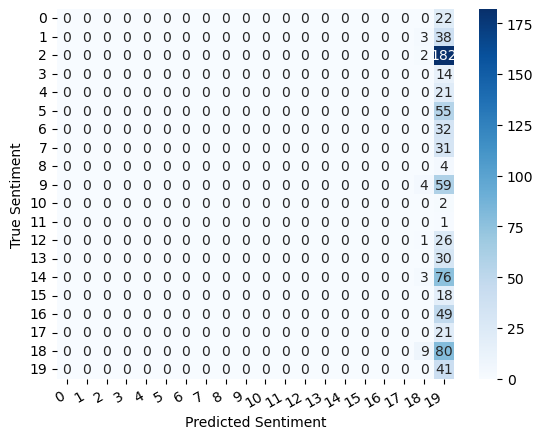

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

In [ ]:
torch.save(model.state_dict(), ' sentiment_model.pt')